Il me reste à : 
- calculer les cij avec soit l'inversion de matrice, soit la minimsation du carré
- borner théoriquement la queue du noyau
- mettre les preuves en md 
- traduire en anglais ^^

- (optionnel) implémenter une meilleure méthode pour calculer les petits bouts d'intégrale (genre quadrature de gauss)

POUR DEBUGGER : 

BIEN REGARDER LES FONCTIONS RIEMANN (le dernier riemann fait nimp)

CHERCHER TOUS LES POINTS QUI DONNENT NAN ; ESSAYER DE TRACER LES FONCTIONS

In [1]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).

prec = 300
R = RealBallField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W


n = 6 
a_derivs = [a]
b_derivs = [b]
for k in range(1, n+1):
    a_deriv_k = diff(a, x, k)
    b_deriv_k = diff(b, x, k)
    a_derivs.append(a_deriv_k)
    b_derivs.append(b_deriv_k)


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] # corresponds to the sign in the inequality
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1]
phi_list = [phi_0, phi_1, phi_2, phi_3]


# Base Fourier function
f = (1 + 4*pi*abs(x) + 4*pi^2*x^2) * exp(-2*pi*abs(x)) / 8
lambda_0 = f
lambda_1 = diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4]


M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y)).simplify_full()
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[0], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y)).simplify_full()
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y)).simplify_full()
M_list=[M_0,M_1,M_2]

In [2]:
# Convert symbolic functions to numerical ones evaluable on RealBallField elements
a_funcs = [fast_callable(expr, vars=[x], domain=R) for expr in a_derivs]
b_funcs = [fast_callable(expr, vars=[x], domain=R) for expr in b_derivs]
phi_funcs = [fast_callable(phi_expr, vars=[x], domain=R) for phi_expr in phi_list]
lambda_funcs = [fast_callable(lambda_expr, vars=[x], domain=R) for lambda_expr in lambda_list]
M=[fast_callable(expr, vars=[x,y], domain=R) for expr in M_list]

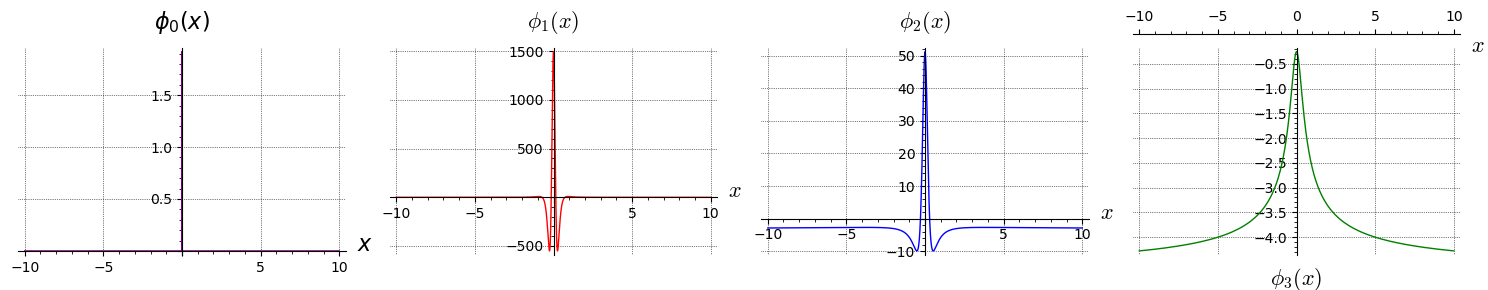

In [3]:
plots = []
colors = ['purple', 'red', 'blue', 'green']

for k in range(4):
    axes_label = [r'$x$', f'$\\phi_{{{k}}}(x)$']
    p = plot(phi_list[k], (x, -10, 10), color=colors[k], figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])


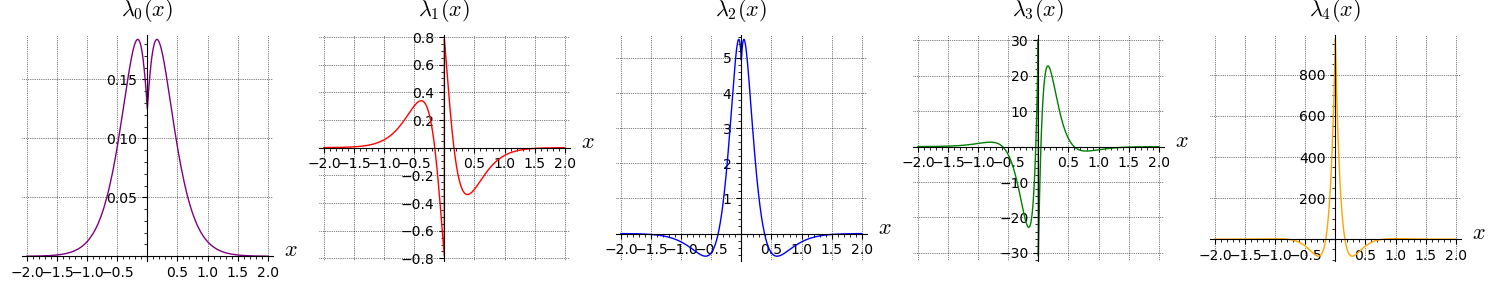

In [4]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(5):
    axes_label = [r'$x$', f'$\\lambda_{{{k}}}(x)$']
    p = plot(lambda_list[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [5]:
x0 = R(0.00001)

print("Evaluations of the derivatives of a at x =",float(x0),":")
for k in range(n+1):
    a_val = a_funcs[k](x0)
    print(f"d^{k}a/dx^{k}({x0.center():.2f}) = {a_val}")

Evaluations of the derivatives of a at x = 1e-05 :
d^0a/dx^0(0.00) = [-0.999999999600000000179999934461556927728148457565528156356015115547536403456483866060 +/- 4.25e-85]
d^1a/dx^1(0.00) = [7.99999999280000066018442954090451418302603007506383991200216667789567957271e-5 +/- 6.01e-80]
d^2a/dx^2(0.00) = [7.99999997840000002879999643530808036704307882998627405573429556791576037841 +/- 8.99e-75]
d^3a/dx^3(0.00) = [-0.00431999998848000037186919005791452155419451467809983061790114200052 +/- 5.77e-69]
d^4a/dx^4(0.00) = [-431.99999654400000923999941806625439340692582122669464729386168296 +/- 1.13e-63]
d^5a/dx^5(0.00) = [0.691199996304000066448893939345786641078719523081731933809 +/- 9.67e-58]
d^6a/dx^6(0.00) = [69119.998891200004953311805293271527846051226448098266191 +/- 5.09e-52]


In [6]:
def rigorous_max_partial_derivatives(f, x1, x2, y1, y2):

    I_x = R(x1, x2)
    I_y = R(y1, y2)

    fx = diff(f, x)
    fy = diff(f, y)

    fx_eval = R(fx(x=I_x, y=I_y))
    fy_eval = R(fy(x=I_x, y=I_y))

    fx_sup = R(max(abs(fx_eval.lower()), abs(fx_eval.upper())))
    fy_sup = R(max(abs(fy_eval.lower()), abs(fy_eval.upper())))

    return fx_sup, fy_sup

def riemann_integral(f_expr, x1, x2, y1, y2, n):

    f_num = fast_callable(f_expr, vars=[x, y], domain=R)

    dx = (R(x2) - R(x1))/n
    dy = (R(y2) - R(y1))/n

    total = R(0)
    for i in range(n):
        for j in range(n):
            xi = R(x1) + i*dx
            yj = R(y1) + j*dy
            total += f_num(xi, yj) * dx * dy
        
        percent = int((i / n) * 100)
        sys.stdout.write(f"\rProgression : {percent}%") # Progress bar
        sys.stdout.flush()

    #max_fx, max_fy = rigorous_max_partial_derivatives(f_expr, x1, x2, y1, y2)

    # Calcul borne d'erreur théorique
    # largeur = R(x2) - R(x1)
    # hauteur = R(y2) - R(y1)
    # error_bound = (largeur * hauteur / n) * (largeur * max_fx + hauteur * max_fy)
    return total #,error_bound

f_expr = M_0
approx_integral  = riemann_integral(f_expr,-1,1,-1,1, n=100)

print(f"\rApproximation de l'intégrale : {approx_integral}")
# print(f"Borne d'erreur théorique (approx.) : {error_bound}")
# print("L'intégrale est contenue dans l'intervalle [",float((approx_integral-error_bound).lower()) ,",",float((approx_integral+error_bound).upper()),"]")

Approximation de l'intégrale : nan


In [7]:
def riemann_integral2(f_expr, x1, x2, y1, y2, n):
    var('x y')
    f_num = fast_callable(f_expr, vars=[x, y], domain=R)

    dx = (R(x2) - R(x1)) / n
    dy = (R(y2) - R(y1)) / n

    total = R(0)
    skipped = 0

    for i in range(n):
        for j in range(n):
            xi = R(x1) + (i + R(1/2)) * dx  # Milieu de la cellule
            yj = R(y1) + (j + R(1/2)) * dy

            # Exclusion explicite des points où x = y (u = 0)
            if xi == yj:
                skipped += 1
                continue

            try:
                total += f_num(xi, yj) * dx * dy
            except ZeroDivisionError:
                skipped += 1
                continue

        # Progression
        percent = int((i / n) * 100)
        sys.stdout.write(f"\rProgression : {percent}%")
        sys.stdout.flush()

    print(f"\nPoints ignorés pour singularité : {skipped}")
    return total


f_expr = M_2
approx_integral2  = riemann_integral2(f_expr,-1,1,-1,1, n=100)

print(f"\rApproximation de l'intégrale : {approx_integral2}")

Progression : 99%
Points ignorés pour singularité : 0
Approximation de l'intégrale : nan


In [8]:
print(M[2](0.0001,0.0002))
print(M[2](0.000001,0.000002))
print(M[2](0.00000000001,0.00000000002))

[-38594.728954406796635233580221186791290384815178608059438729398190358271 +/- 1.62e-67]
[-38784.87903241411737352223048058317830851496302709908673370152 +/- 5.77e-57]
[-38786.7984082177185357680153766078364 +/- 6.34e-32]


In [20]:
def riemann_integral_nan_debug(f_expr, x1, x2, y1, y2, n, epsilon=0.01):
    
    f_num = fast_callable(f_expr, vars=[x, y], domain=R)

    x1 = R(x1)
    x2 = R(x2)
    y1 = R(y1)
    y2 = R(y2)
    epsilon = R(epsilon)
    n = n

    dx =  R(x2) - R(x1) / R(n)
    dy = (R(y2) - R(y1)) / R(n)

    total = R(0)
    skipped = 0
    nan_points = []

    for i in range(n):
        for j in range(n):
            xi = x1 + (i + R(0.0000001)) * dx
            yj = y1 + (j + R(0.0000001)) * dy

            # exclusion autour de la singularité x = y
            if abs(xi - yj) < epsilon:
                skipped += 1
                continue

            try:
                val = f_num(xi, yj)
                if math.isnan(float(val)):
                    nan_points.append((float(xi), float(yj)))
                    skipped += 1
                    continue
                total += val * dx * dy
            except Exception as e:
                print(f"Erreur à ({xi}, {yj}) : {e}")
                skipped += 1
                continue

        percent = int((i / n) * 100)
        sys.stdout.write(f"\rProgression : {percent}%")
        sys.stdout.flush()

    print(f"\nPoints ignorés (NaN ou singularités) : {skipped}")
    if nan_points:
        print(f"\nPoints NaN détectés ({len(nan_points)}) :")
        for pt in nan_points:
            print(f"  x = {pt[0]:.6f}, y = {pt[1]:.6f}")

    return total


f_expr = M_0+ M_1+ M_2 

approx_integral3 = riemann_integral_nan_debug(f_expr, -1, 1, -1, 1, n=100, epsilon=0.0000000000001)
print(f"\nApproximation de l'intégrale : {approx_integral3}")


Progression : 99%
Points ignorés (NaN ou singularités) : 0

Approximation de l'intégrale : [53290.3369843182953574 +/- 8.48e-17]


In [10]:
import random

x_points = [R(2 * random.random() - 1) for _ in range(100)]
y_points = [R(2 * random.random() - 1) for _ in range(100)]
for xi in x_points:
    for yi in y_points :
        print(M[2](xi, yi))


[66357.680352782525934191341495689273375023315337394936370754916707358691963347765 +/- 7.85e-76]
[15937.73894677023089232501466302500048641727596093575838779189363139375149142738056124 +/- 5.86e-81]
[-1310.5347019894381815529876964890738114311320097551166912982914282940454318814144369989 +/- 4.61e-83]
[2682.4181332883565688765080149730579102884504912558828750496354866017577095421107304217 +/- 2.26e-83]
[23.22031063312205158063407637249365272497671021473504784159840955613415172338175313767 +/- 8.79e-84]
[10016.0895380222024289649564238444099610625111175060789173858864445069712608561855792787 +/- 7.90e-83]
[74.64575483799644773302858934548199521905603408222316455598332866461518731129553248743 +/- 1.44e-84]
[-2069.1402695993303382092865936605619406784916013082892395925444561743402277116091009402 +/- 6.50e-83]
[-3429.6008405013961779070035422924370684934665274536288566655303205922242718052219369662 +/- 4.73e-83]
[12637.37567406878997411524519807728639610266568644664639467656767575107756350